# Introduction to Langgraph Store
- Provides a way to store and retrieve information across threads
- Presistent Key-value store
- When storing memories in Store, we provide:
    - namespace: for the object, a tuple
    - key
    - value
    - put to save object to the store by namespace and key 

In [1]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [2]:
# Namespace for memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = {"food_preference": "I like pizza"}

# store in memory
in_memory_store.put(namespace_for_memory, key, value)

In [3]:
# Search for a memory
memories = in_memory_store.search(namespace_for_memory)
memories

[Item(namespace=['1', 'memory'], key='d57b8449-45d8-499b-9076-a7e9a9f03cb2', value={'food_preference': 'I like pizza'}, created_at='2025-08-25T04:39:29.702217+00:00', updated_at='2025-08-25T04:39:29.702218+00:00', score=None)]

In [4]:
print(memories[0].key, memories[0].value)

d57b8449-45d8-499b-9076-a7e9a9f03cb2 {'food_preference': 'I like pizza'}


In [5]:
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memory'],
 'key': 'd57b8449-45d8-499b-9076-a7e9a9f03cb2',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-08-25T04:39:29.702217+00:00',
 'updated_at': '2025-08-25T04:39:29.702218+00:00'}

# Chatbot with longterm memory
- Short term memory: Chatbot persists conversation history and/ or allow interruptions in chat
- Long term memory: Chatbot can remember information about a specific user across all chat sessions

In [6]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b", temperature=0)
#llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [7]:
llm.invoke("hello I am John Doe!")

AIMessage(content='Hello, John! 👋 How can I help you today?', additional_kwargs={'reasoning_content': 'User says "hello I am John Doe!" They want a greeting. Probably respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 77, 'total_tokens': 118, 'completion_time': 0.036494418, 'prompt_time': 0.005706051, 'queue_time': 0.195682218, 'total_time': 0.042200469}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_fd68d84dd3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--80a5978e-0019-48fc-8efc-d92ec425d16d-0', usage_metadata={'input_tokens': 77, 'output_tokens': 41, 'total_tokens': 118})

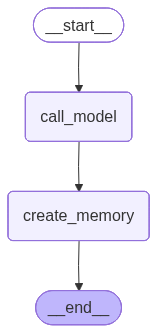

In [11]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# chatbot instruction
MODEL_SYSTEM_PROMPT = """ 
You are a helpful assistant with memory that provides information about user.
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}
"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_PROMPT = """ 
You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully.
2. Identify new information about the user such as:
    - Personal information (name, location, phone number, email, linkedin profile, github profile, portfolio, etc.)
    - Professional Summary(1-2 sentences)
    - Education (Degree, School, Graduation Year)
    - Work Experience (jobtitle, company, dates, responsibilities, links)
    - Publications (title, date, journal, link)
    - Technical Skills (programming languages, frameworks, tools, any specific skills focused on things like (AI, Machine Learning, Data Science, etc.))
    - Projects (title, description, skills, links)
    - Preferences (likes, dislikes)
    - Interests and hobbies
    - Goals or future plans
3. Merge any new information with the existing memory.
4. Format the memory as clear, bulleted list.
5. If the information conflicts with existing memory, keep the most recent version.

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences

Based on the chat history below, please update the user history.
"""

def call_model(state:MessagesState, config:RunnableConfig, store:BaseStore):
    """ Load memory from store and personalize the chatbot's response """
    
    # get user ID from the config
    user_id = config["configurable"]["user_id"]
    
    # Retrieve memory from store
    namespace = ('memory', user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found"
    
    # format the memory
    system_message = MODEL_SYSTEM_PROMPT.format(memory=existing_memory_content)
    
    # respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_message)] + state['messages'])
    
    return {'messages': [response]}

def write_memory(state:MessagesState, config:RunnableConfig, store:BaseStore):
    """ Create new memory from the chat history and any existing memory """
    
    # get user ID from the config
    user_id = config["configurable"]["user_id"]
    
    # retrieve existing memory
    namespace = ('memory', user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)
    
    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found"

    system_message = CREATE_MEMORY_PROMPT.format(memory=existing_memory_content)
    new_memory = llm.invoke([SystemMessage(content=system_message)] + state['messages'])
    
    store.put(namespace, key, {"memory": new_memory.content})   

# build graph
memory_builder = StateGraph(MessagesState)
memory_builder.add_node("call_model", call_model)
memory_builder.add_node("create_memory", write_memory)
memory_builder.add_edge(START, "call_model")
memory_builder.add_edge("call_model", "create_memory")
memory_builder.add_edge("create_memory", END)

# Store memory for Long term memory
across_thread_memory = InMemoryStore()
within_thread_memory = MemorySaver()
memory_graph = memory_builder.compile(checkpointer = within_thread_memory,store = across_thread_memory)

display(Image(memory_graph.get_graph().draw_mermaid_png()))



In [12]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Saumya")]

# Run the graph
for chunk in memory_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Saumya
================================== Ai Message ==================================

Hello Saumya! 👋 How can I help you today?


In [13]:
# User input 
input_messages = [HumanMessage(content="I am a Senior Data Scientist")]

# Run the graph
for chunk in memory_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I am a Senior Data Scientist
================================== Ai Message ==================================

Nice to meet you, Saumya! 👋 As a Senior Data Scientist, you’re probably juggling a mix of modeling, data engineering, and stakeholder communication. How can I support you today? Are you looking for help with a specific project, exploring new techniques, or maybe something else?


# Testing if the model can remember user profile from it's long term memory


In [15]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What do you recommend I focus on for my resume?")]

# Run the graph
for chunk in memory_graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What do you recommend I focus on for my resume?
================================== Ai Message ==================================

Hi Saumya!  
As a Senior Data Scientist, your resume is your “first pitch” to recruiters and hiring managers.  Below are the key areas I’d recommend you focus on, along with a quick checklist so you can make sure each section hits the mark.

---

## 1. Executive Summary / Professional Profile  
- **Keep it 2–3 lines.**  
- Highlight **years of experience**, **core domains** (e.g., predictive modeling, NLP, computer vision), and a **quantifiable impact** (e.g., “boosted revenue by 12% through model‑driven pricing”).  
- Mention any **leadership** or **cross‑functional** experience (e.g., “led a team of 5 data scientists on a multi‑year AI strategy”).

> **Example**  
> *Senior Data Scientist with 8+ years of experience in predictive analytics, machine learning, and AI strategy. 

# Trustcall
- Helps with complex or hard to generate schemas
- We don't have to generate schemas from scratch every time we want to update something in memory

In [37]:
from trustcall import create_extractor
from pydantic import BaseModel, Field
from typing import List

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    first_name: str = Field(description="The first name of the user")
    last_name: str = Field(description="The last name of the user")
    state: str = Field(description="The state of the user")
    email: str = Field(description="The email of the user")
    phone: str = Field(description="The phone number of the user")
    address: str = Field(description="The address of the user")
    city: str = Field(description="The city of the user")
    zip: str = Field(description="The zip code of the user")
    


# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor

trust_call_extractor = create_extractor(
    llm,
    tools=[UserProfile],
    tool_choice="UserProfile"
    )

In [44]:
system_message = "Extract the user profile from the following conversation"
conversation = [HumanMessage(content="My name is John Doe and I live at 123 Main St, San Francisco, CA 94101"),
                HumanMessage(content="My email is john.doe@gmail.com"),
                ]
result = trust_call_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})
schema = result['responses']
schema

[UserProfile(first_name='John', last_name='Doe', state='CA', email='john.doe@gmail.com', phone='', address='123 Main St', city='San Francisco', zip='94101')]

In [47]:
# Update the instruction
updated_conversation = [HumanMessage(content="My name is John Doe and I live at 123 Main St, San Francisco, CA 94101"),
                HumanMessage(content="My email is john.doe@gmail.com"),
                HumanMessage(content="I recently moved to 2345 Broadway, Phoenix, AZ 85004")]
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trust_call_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [48]:
result['responses'][0].model_dump()

{'first_name': 'John',
 'last_name': 'Doe',
 'state': 'AZ',
 'email': 'john.doe@gmail.com',
 'phone': '',
 'address': '2345 Broadway',
 'city': 'Phoenix',
 'zip': '85004'}

In [ ]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"First Name: {memory_dict.get('first_name', 'Unknown')}\n"
            f"Last Name: {memory_dict.get('last_name', 'Unknown')}\n"
            f"Phone: {', '.join(memory_dict.get('phone', 'Unknown'))}\n"
            f"Email: {', '.join(memory_dict.get('email', 'Unknown'))}\n"
            f"Address: {', '.join(memory_dict.get('address', 'Unknown'))}\n"
            f"State: {', '.join(memory_dict.get('state', 'Unknown'))}\n" 
            f"City: {', '.join(memory_dict.get('city', 'Unknown'))}\n"  
            f"Zip: {', '.join(memory_dict.get('zip', 'Unknown'))}\n"  
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trust_call_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))